### Исследование регионов Великобритании по параметрам университетов

Выбор университета происходит преимущественно по наличию интересующих образовательных программ, его рейтингу, стоимости обучения и прочим параметрам.

Однако, существует важный момент, на который не все обращают внимание при выборе университета - это жизнь в том месте, где университет находится.

Цель данного проекта - изучить параметры университетов в регионах 
и получить информацию с особенностями для каждого региона, что могло бы помочь студентам при выборе региона, в котором они хотят учиться.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns
from matplotlib import pyplot as plt

/kaggle/input/best-universities-in-the-united-kingdom/uk_universities.csv


In [2]:
uk_uni_df = pd.read_csv('../input/best-universities-in-the-united-kingdom/uk_universities.csv')

In [3]:
uk_uni_df.head()

,University_name,Region,Founded_year,Motto,UK_rank,World_rank,CWUR_score,Minimum_IELTS_score,UG_average_fees_(in_pounds),PG_average_fees_(in_pounds),...,Student_satisfaction,Student_enrollment,Academic_staff,Control_type,Academic_Calender,Campus_setting,Estimated_cost_of_living_per_year_(in_pounds),Latitude,Longitude,Website
0,University of Cambridge,East of England,1209,"From here, light and sacred draughts",1,4,94.1,6.5,21750,23187,...,85.50%,"20,000-24,999","over-5,000",Public,Trimesters,Urban,12000,52.2054,0.1132,www.cam.ac.uk
1,University of Oxford,South East England,1096,The Lord is my light,2,2,93.3,6.5,21770,19888,...,86.50%,"25,000-29,999","over-5,000",Public,Trimesters,Urban,11500,51.7548,-1.2544,www.ox.ac.uk
2,University of St Andrews,Scotland,1413,Ever to excel,3,86,75.8,6.5,17040,15440,...,87.90%,"10,000-14,999","1,000-1,499",Public,Semesters,Suburban,12000,56.3417,-2.7943,www.st-andrews.ac.uk
3,Imperial College London,London,1907,Knowledge is the adornment and safeguard of th...,4,8,86.6,6.5,23500,29900,...,77.90%,"15,000-19,999","4,000-4,499",Public,Continuous,Urban,10700,51.4988,-0.1749,www.ic.ac.uk
4,Loughborough University,East Midlands,1966,"With Truth, Knowledge and Labour",5,404,72.8,5.5,16400,16400,...,85.80%,"15,000-19,999","1,500-1,999",Public,Semesters,Suburban,9398,52.7650,-1.2321,www.lboro.ac.uk/


In [4]:
uk_uni_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 21 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   University_name                                131 non-null    object 
 1   Region                                         131 non-null    object 
 2   Founded_year                                   131 non-null    int64  
 3   Motto                                          114 non-null    object 
 4   UK_rank                                        131 non-null    int64  
 5   World_rank                                     131 non-null    int64  
 6   CWUR_score                                     84 non-null     float64
 7   Minimum_IELTS_score                            131 non-null    float64
 8   UG_average_fees_(in_pounds)                    131 non-null    int64  
 9   PG_average_fees_(in_pounds)                    131 non

Нужно исследовать по кажому региону следующие параметры:
- удовлетворённость студентов (основной показатель)
- стоимость жизни (чтобы оценить необходимый бюджет)
- число студентов (для тех, кому важно большое комьюнити)
- процент иностранных студентов

## Анализ данных

### Удовлетворённость студентов по регионам

In [5]:
# преобразование колонок, содержащих проценты
uk_uni_df.Student_satisfaction = uk_uni_df.Student_satisfaction.str.replace('%','').astype('float')
uk_uni_df.International_students = uk_uni_df.International_students.str.replace('%','').astype('float')
uk_uni_df = uk_uni_df.rename(columns={'Student_satisfaction': 'Percent_of_student_satisfaction', 'International_students': 'Percent_of_international_students'})

В пределах одного региона значения Student_satisfaction могут быть разнообразны, \
стоит посмотреть на их распределние.

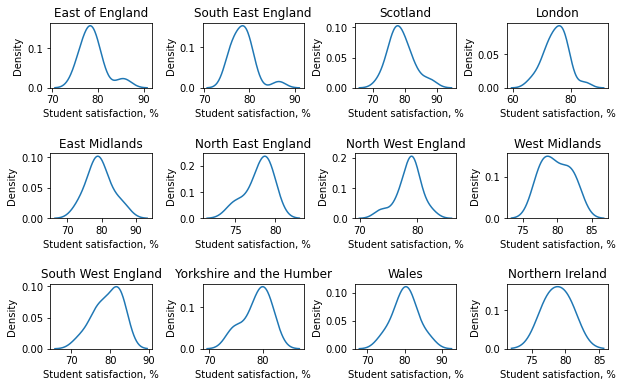

In [6]:
# распределение Student_satisfaction по регионам
ur = uk_uni_df.Region.unique()
plt.figure(figsize=(10,6))
for i in range(len(ur)):
    plt.subplot(3, 4, i+1)
    plt.subplots_adjust(wspace=0.5, hspace=1)
    plt.title(ur[i])
    sns.kdeplot(data = uk_uni_df[uk_uni_df.Region == ur[i]], x = 'Percent_of_student_satisfaction').set(xlabel='Student satisfaction, %')

Видно, что распредление близко к нормальному, однако есть различные деформации графиков. \
Посмотрим на данные, используя boxplot.

[Text(0, 0.5, 'Student satisfaction, %')]

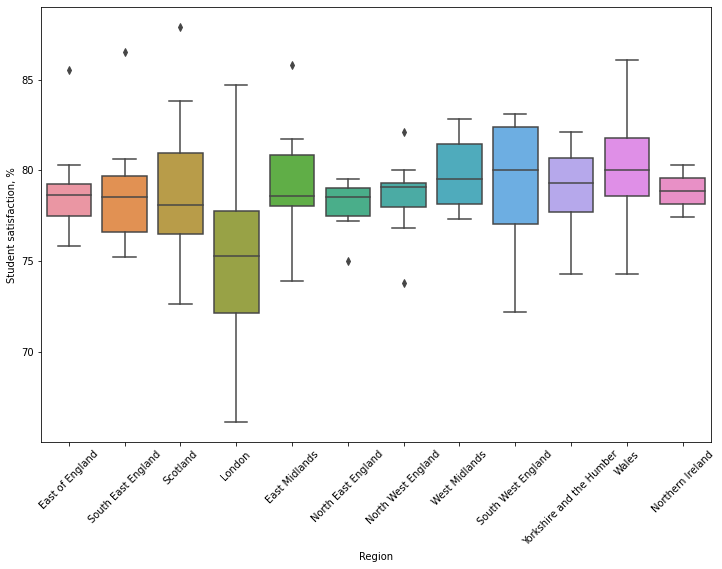

In [7]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
sns.boxplot(data = uk_uni_df, x = 'Region', y = 'Percent_of_student_satisfaction').set(ylabel='Student satisfaction, %')

In [8]:
PoSS = uk_uni_df.groupby('Region').Percent_of_student_satisfaction.mean()

Заметно, что удовлетворённость студентов в Лондоне ниже, чем в остальных регионах. \
Проверим эту гипотезу...

H0: удовлетворённость студентов Лондона не отличается \
H1: удовлетворённость студентов Лондона отличается

In [9]:
def delete_outliers(df, column, graphic=0, x = 10, y = 10):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))
    if graphic == 1:
        return df.loc[iqr_test].boxplot([column], figsize=(x,y))
    else:
        return df.loc[iqr_test]

In [10]:
londstuds = uk_uni_df[uk_uni_df['Region'] == 'London']
nonlondstuds = uk_uni_df[uk_uni_df['Region'] != 'London']

londstuds = delete_outliers(londstuds, 'Percent_of_student_satisfaction', 0)
londstuds = londstuds['Percent_of_student_satisfaction']

nonlondstuds = delete_outliers(nonlondstuds, 'Percent_of_student_satisfaction', 0)
nonlondstuds = nonlondstuds['Percent_of_student_satisfaction']

In [11]:
alpha = 0.05
results = st.ttest_ind(londstuds, nonlondstuds)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-value: 4.63997406298399e-09
Отвергаем нулевую гипотезу


Удовлетворённость студентов в Лондоне действительно ниже, чем в остальных регионах

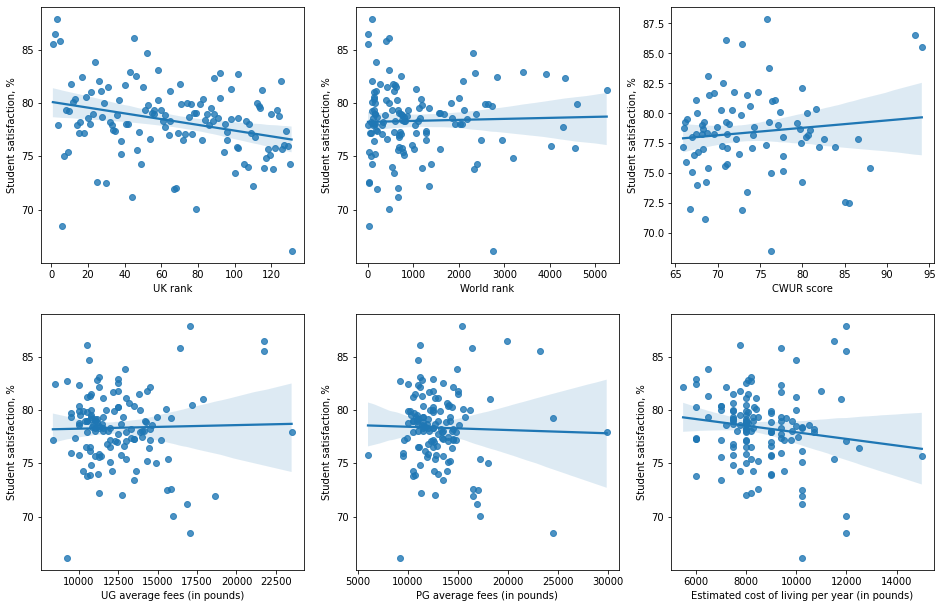

In [12]:
# влияние разных факторов на удовлетворённость студентов
fctr = ['UK_rank', 'World_rank', 'CWUR_score',
        'UG_average_fees_(in_pounds)', 'PG_average_fees_(in_pounds)',
        'Estimated_cost_of_living_per_year_(in_pounds)']
plt.figure(figsize=(16,16))
for i in range(len(fctr)):
    plt.subplot(3, 3, i+1)
    sns.regplot(data = uk_uni_df, y = 'Percent_of_student_satisfaction', x = fctr[i]).set(ylabel='Student satisfaction, %', xlabel=fctr[i].replace('_',' '))

Корреляции между рейтингами/стоимостями и удовлетворённостью студентов практически не наблюдается, за исключением небольшой корреляции по UK_rank, однако это объясняется тем, что при составлении рейтинга внутри Великобритании учитывается удовлетворённость студентов.

### Оценочная стоимость проживания в год по каждому региону

Стоимость будет в той или иной степени варьироваться по регионам. \
Однако, она может также изменяться от расположения кампуса.

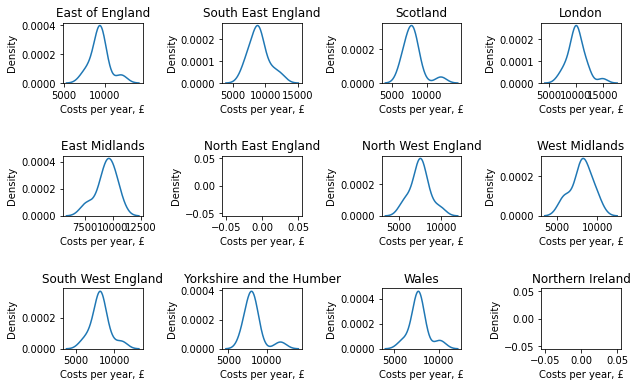

In [13]:
# распределение Estimated_cost_of_living_(in_pounds) по регионам
ur = uk_uni_df.Region.unique()
plt.figure(figsize=(10,6))
for i in range(len(ur)):
    plt.subplot(3, 4, i+1)
    plt.subplots_adjust(wspace=1, hspace=1.2)
    plt.title(ur[i])
    sns.kdeplot(data = uk_uni_df[uk_uni_df.Region == ur[i]], x = 'Estimated_cost_of_living_per_year_(in_pounds)', warn_singular = False).set(xlabel='Costs per year, £')

Два графика не отобразились, посмотрим на их данные отдельно.

In [14]:
uk_uni_df[uk_uni_df.Region == 'North East England']['Estimated_cost_of_living_per_year_(in_pounds)']

6      8000
27     8000
54     8000
64     8000
86     8000
108    8000
Name: Estimated_cost_of_living_per_year_(in_pounds), dtype: int64

In [15]:
uk_uni_df[uk_uni_df.Region == 'Northern Ireland']['Estimated_cost_of_living_per_year_(in_pounds)']

34    6000
58    6000
Name: Estimated_cost_of_living_per_year_(in_pounds), dtype: int64

Их значения одинаковые, это равномерное распределение, поэтому kdeplot и не строится.

[Text(0.5, 0, 'Costs per year, £')]

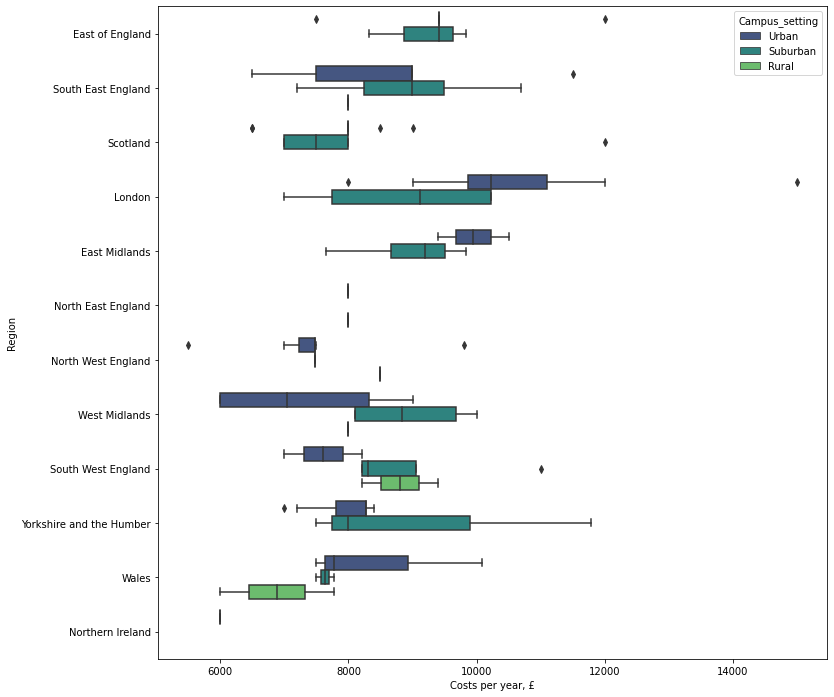

In [16]:
plt.figure(figsize=(12,12))
sns.boxplot(data = uk_uni_df, y = 'Region', x = 'Estimated_cost_of_living_per_year_(in_pounds)', hue = 'Campus_setting', palette='viridis').set(xlabel='Costs per year, £')

Видим, что оценочная стоимость жизни действительно изменяется в зависимости от региона и расположения кампуса. \
Однако, по некоторым вариантам расположения кампуса информации практически нет. \
Это может быть связано с null значениями, что и видно в .info() выше (Campus_setting: 113 non-null значений из 131)

In [17]:
# процент null значений по Campus_setting
cs_n = round((uk_uni_df[uk_uni_df['Campus_setting'].isna() == True].groupby('Region').Region.count() / uk_uni_df.groupby('Region').Region.count() * 100), 2).dropna().sort_values(ascending = False)
cs_n

Region
South West England    33.33
South East England    23.53
Wales                 22.22
North West England    18.18
East Midlands         14.29
London                13.64
East of England       10.00
West Midlands         10.00
Name: Region, dtype: float64

При описании стоимости жизни по регионам стоит учитывать отсутствие записей. \
Для регионов, где null значений по Campus_setting больше 20%, подпишем замечание о том, что стоит уточнить информацию о стоимости жизнь при выборе этих регионов.

In [18]:
# стоимость жизни по регионам и расположению кампуса
ECoL = uk_uni_df.groupby(['Region', 'Campus_setting'])['Estimated_cost_of_living_per_year_(in_pounds)'].median().sort_values()
ECoL_df = pd.DataFrame(ECoL)
ECoL

Region                    Campus_setting
Northern Ireland          Urban              6000.0
Wales                     Rural              6885.5
West Midlands             Urban              7048.5
North West England        Suburban           7471.0
                          Urban              7471.0
Scotland                  Suburban           7500.0
South West England        Urban              7608.5
Wales                     Suburban           7635.5
                          Urban              7771.0
Scotland                  Urban              8000.0
West Midlands             Rural              8000.0
North East England        Rural              8000.0
                          Urban              8000.0
Yorkshire and the Humber  Suburban           8000.0
South East England        Rural              8000.0
Yorkshire and the Humber  Urban              8270.0
South West England        Suburban           8308.5
North West England        Rural              8500.0
South West England     

### Число студентов (и преподавателей)

Данные представленны в виде диапазонов, записанных как строчки, поэтому необходимо преобразовать их.

In [19]:
uk_uni_df.Student_enrollment.unique()

array(['20,000-24,999', '25,000-29,999', '10,000-14,999', '15,000-19,999',
       '40,000-44,999', '35,000-39,999', '30,000-34,999', '5,000-5,999',
       '6,000-6,999', '3,000-3,999', '7,000-7,999', '2,000-2,999',
       '4,000-4,999', '1,000-1,999', '9,000-9,999', '8,000-8,999'],
      dtype=object)

In [20]:
uk_uni_df.Academic_staff.unique()

array(['over-5,000', '1,000-1,499', '4,000-4,499', '1,500-1,999',
       '2,000-2,499', '2,500-2,999', '3,500-3,999', '3,000-3,499',
       '100-199', '800-899', '300-399', '700-799', '400-499', '900-999',
       '200-299', '500-599', '600-699', '50-99'], dtype=object)

In [21]:
def range_to_mean(str0):
    s = str0.replace(',', '').split('-')
    if s[0] == 'over':
        m = int(s[1])
    else:
        m = (int(s[0]) + int(s[1])) / 2
        m = round(m)
    return m
    
uk_uni_df['Approx_stud_enrollment'] = uk_uni_df.Student_enrollment.apply(range_to_mean)
uk_uni_df['Approx_academic_staff'] = uk_uni_df.Academic_staff.apply(range_to_mean)

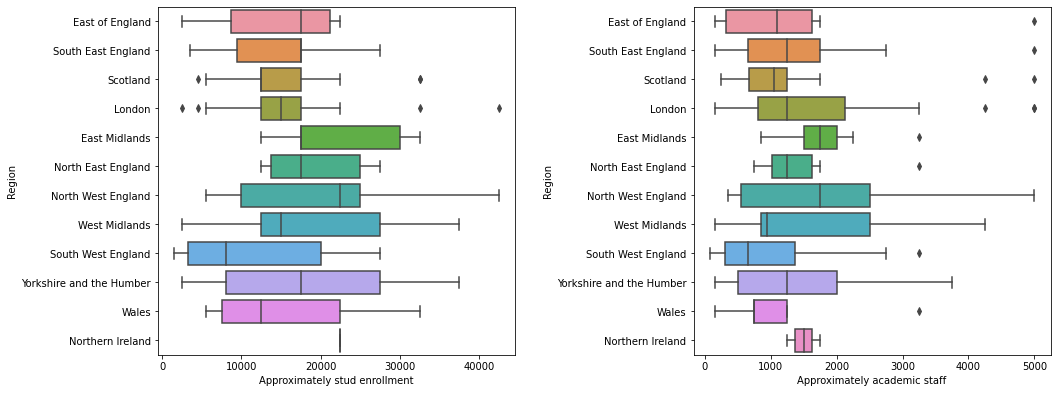

In [22]:
ppl = ['Approx_stud_enrollment', 'Approx_academic_staff']
plt.figure(figsize=(16,16))
for i in range(len(ppl)):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    sns.boxplot(data = uk_uni_df, x = ppl[i], y = 'Region').set(xlabel=ppl[i].replace('_',' ').replace('Approx','Approximately'))

Видно, что данные по большинству регионов довольно широко распределены, поэтому учитывать число студентов в университете всё же лучше независимо от региона.

In [23]:
AprSE = round(uk_uni_df.groupby('Region').Approx_stud_enrollment.mean().sort_values(ascending = False), 2)

### Число иностранных студентов

[Text(0, 0.5, 'International students, %')]

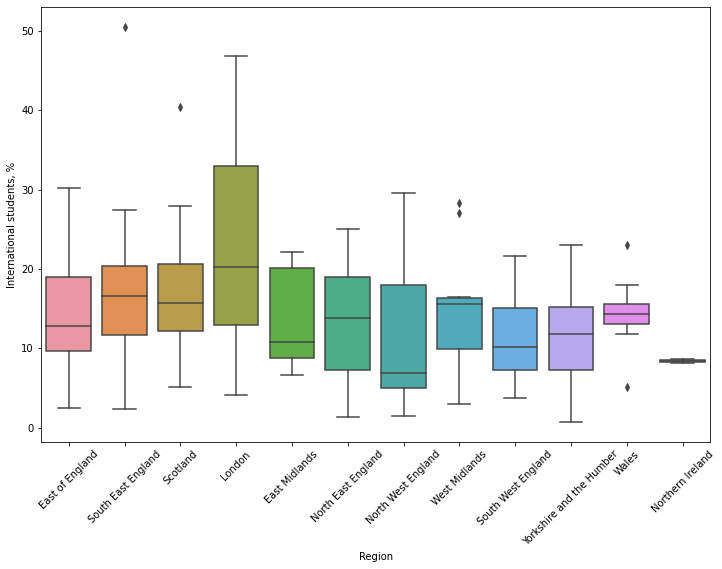

In [24]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
sns.boxplot(data = uk_uni_df, x = 'Region', y = 'Percent_of_international_students').set(ylabel='International students, %')

In [25]:
PoIS = uk_uni_df.groupby('Region').Percent_of_international_students.mean().sort_values(ascending = False)
PoIS

Region
London                      22.104091
Scotland                    17.664286
South East England          17.429412
West Midlands               14.908000
Wales                       14.521111
East Midlands               13.914286
East of England             13.909000
North East England          13.350000
Yorkshire and the Humber    11.962727
South West England          11.682500
North West England          11.581818
Northern Ireland             8.450000
Name: Percent_of_international_students, dtype: float64

In [26]:
round((PoIS - PoIS.mean())**2, 2)

Region
London                      61.06
Scotland                    11.39
South East England           9.86
West Midlands                0.38
Wales                        0.05
East Midlands                0.14
East of England              0.14
North East England           0.88
Yorkshire and the Humber     5.42
South West England           6.80
North West England           7.33
Northern Ireland            34.10
Name: Percent_of_international_students, dtype: float64

Больше всего иностранных студентов: Лондон \
Много иностранных студентов: Шотландия, Юго-Восточная Англия \
Мало иностранных студентов: Северная Ирландия

### Оформление результата

In [27]:
# создание таблицы с полученными данными
result_df = pd.DataFrame(columns=['Region', 
                                  'Stud_satisfaction', 
                                  'urban_Costs',
                                  'suburban_Costs',
                                  'rural_Costs',
                                  'Mean_stud_amount',
                                  'Mean_int_studs_percent'])

campus_dict = {'Urban': 'в городе', 'Suburban': 'в пригороде', 'Rural': 'вне города'}

for region in uk_uni_df.Region.unique().tolist():
    
    reg_inf = {'Region': np.NaN, 
               'Stud_satisfaction': np.NaN, 
               'urban_Costs': np.NaN,
               'suburban_Costs': np.NaN,
               'rural_Costs': np.NaN,
               'Mean_stud_amount': np.NaN,
               'Mean_int_studs_percent': np.NaN}
    
    reg_inf['Region'] = region
    reg_inf['Stud_satisfaction'] = round(PoSS[region], 2)
    
    for cs in ['Urban', 'Suburban', 'Rural']:
        try:
            reg_inf[cs.lower()+'_Costs'] = float(ECoL_df.loc[region, cs])
        except:
            continue
    
    reg_inf['Mean_stud_amount'] = int(AprSE[region])
    reg_inf['Mean_int_studs_percent'] = round(PoIS[region], 2)

    result_df = result_df.append(reg_inf, ignore_index=True)

In [28]:
result_df = result_df.sort_values(by = 'Stud_satisfaction', ascending = False).reset_index(drop = True)

In [29]:
# таблица с итоговыми данными
result_df = result_df.fillna('')

## Результат

In [30]:
result_df

,Region,Stud_satisfaction,urban_Costs,suburban_Costs,rural_Costs,Mean_stud_amount,Mean_int_studs_percent
0,Wales,80.19,7771.0,7635.5,6885.5,14833,14.52
1,West Midlands,79.83,7048.5,8838.5,8000.0,19500,14.91
2,East Midlands,79.43,9949.0,9199.0,,22500,13.91
3,South West England,79.34,7608.5,8308.5,8808.5,12416,11.68
4,Scotland,78.90,8000.0,7500.0,,16071,17.66
5,Yorkshire and the Humber,78.85,8270.0,8000.0,,18136,11.96
6,Northern Ireland,78.85,6000.0,,,22500,8.45
7,East of England,78.83,9415.0,9415.0,,14500,13.91
8,North West England,78.57,7471.0,7471.0,8500.0,19500,11.58
9,South East England,78.56,8990.0,8990.0,8000.0,15147,17.43


Выводы:

- Cтуденты во всех регионах примерно одинаково удовлетворены, за исключением Лондона, где этот показатель заметно ниже

- Cтоимость жизни отличается в зависимости от региона и расположения кампуса. Варианты расположения: город - все регионы, пригород - большинство регионов, вне города - половина регионов. Также в Юго-Западной и Юго-Восточной Англии и Уэйльсе отсутстивует более 20% информации по расположению кампуса, поэтому при выборе этих регионов стоит уточнить информацию по стоимости жизни

- Количество студентов в каждом регионе широко распредлено и меняется в зависимости от университета

- Больше всего иностранных студентов в Лондоне, много - Шотландии и Юго-Восточной Англии, а меньше всего - в Северной Ирландии